In [18]:
import logging
logging.basicConfig(level=logging.WARN)

from copy import copy

import gym
import gym_grid

import numpy as np

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2
from lcs.strategies.action_selection import BestAction, EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.experiments import avg_experiments
from utils.plotting import COLORS

from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font',**{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 12})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [2]:
experiments = 50

explore_trials = 60
exploit_trials = 20

## Environment

In [3]:
grid_size = 20  # 5/10/20/40/100

ENV_NAME = f'grid-{grid_size}-v0'
env = gym.make(ENV_NAME)

In [4]:
# visualization (for grid-size = 20 this is readible)
env.reset()
env.render()


('10', '16')
 20 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  $ 
 19 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 18 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 17 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 16 _  _  _  _  _  _  _  _  _  X  _  _  _  _  _  _  _  _  _  _ 
 15 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 14 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 13 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 12 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 11 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 10 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  9 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  8 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  7 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  6 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  5 _  _  _  _  _  _  _  _

In [5]:
def grid_transitions(grid_size):
    MAX_POS = grid_size
    LEFT, RIGHT, UP, DOWN = 0, 1, 2, 3
    
    def _handle_state(state):
        moves = []
        (x, y) = state

        # handle inner rectangle - 4 actions available
        if 1 < x < MAX_POS and 1 < y < MAX_POS:
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        # handle bounds (except corners) - 3 actions available
        if x == 1 and y not in [1, MAX_POS]:  # left bound
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x == MAX_POS and y not in [1, MAX_POS]:  # right bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x not in [1, MAX_POS] and y == 1:  # lower bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

        if x not in [1, MAX_POS] and y == MAX_POS:  # upper bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        # handle corners - 2 actions available
        if x == 1 and y == 1:  # left-down
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

        if x == 1 and y == MAX_POS:  # left-up
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x == MAX_POS and y == 1:  # right-down
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

        return moves
    
    transitions = []
    for x in range(1, MAX_POS+1):
        for y in range(1, MAX_POS+1):
            transitions += _handle_state((x, y))
    
    return transitions

transitions = grid_transitions(grid_size)

In [6]:
def calculate_knowledge(population, environment):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions) * 100.0

In [7]:
# Build agent configuration
# Collect additional population metrics
def grid_metrics(pop, env):
    metrics = {
        'knowledge': calculate_knowledge(pop, env)
    }
    metrics.update(population_metrics(pop, env))
    return metrics

In [8]:
base_params = {
    "classifier_length": 2,
    "number_of_possible_actions": 4,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 1,
    "metrics_trial_frequency": 1,
    "user_metrics_collector_fcn": grid_metrics
}

### Epsilon Greedy (baseline)

In [9]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy
epsilon_greedy_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **epsilon_greedy_params)

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x117e598c0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experiment 23
Executing experiment 24
Executing experiment 25
Exe

### Action Delay Bias

In [10]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **action_delay_params)

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x117e598c0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experiment 23
Executing experiment 24

### Knowledge Array Bias

In [11]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **knowledge_array_params)

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x117e598c0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experiment 23
Executing experim

### Optimistic Initial Quality

In [12]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(experiments, env, explore_trials, exploit_trials, **op_initial_params)

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x117e598c0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
Executing experiment 10
Executing experiment 11
Executing experiment 12
Executing experiment 13
Executing experiment 14
Executing experiment 15
Executing experiment 16
Executing experiment 17
Executing experiment 18
Executing experiment 19
Executing experiment 20
Executing experiment 21
Executing experiment 22
Executing experiment 23
Executing experiment 24
Executing experiment 25
Exe

Sneak peek into collected metrics

In [13]:
epsilon_greedy_df[:5]

,phase,steps_in_trial,reward,knowledge,population,numerosity,reliable
trial,,,,,,,
0,explore,1338.62,500.0,65.372859,74.32,485.14,51.72
1,explore,1550.02,400.0,91.976285,85.54,962.20,73.50
2,explore,1362.38,540.0,96.865613,85.78,1221.50,77.66
3,explore,1173.26,640.0,98.525692,85.70,1349.36,79.12
4,explore,1152.60,640.0,99.525692,84.86,1445.28,80.12


## Vizualization
### Aggregated performance plot

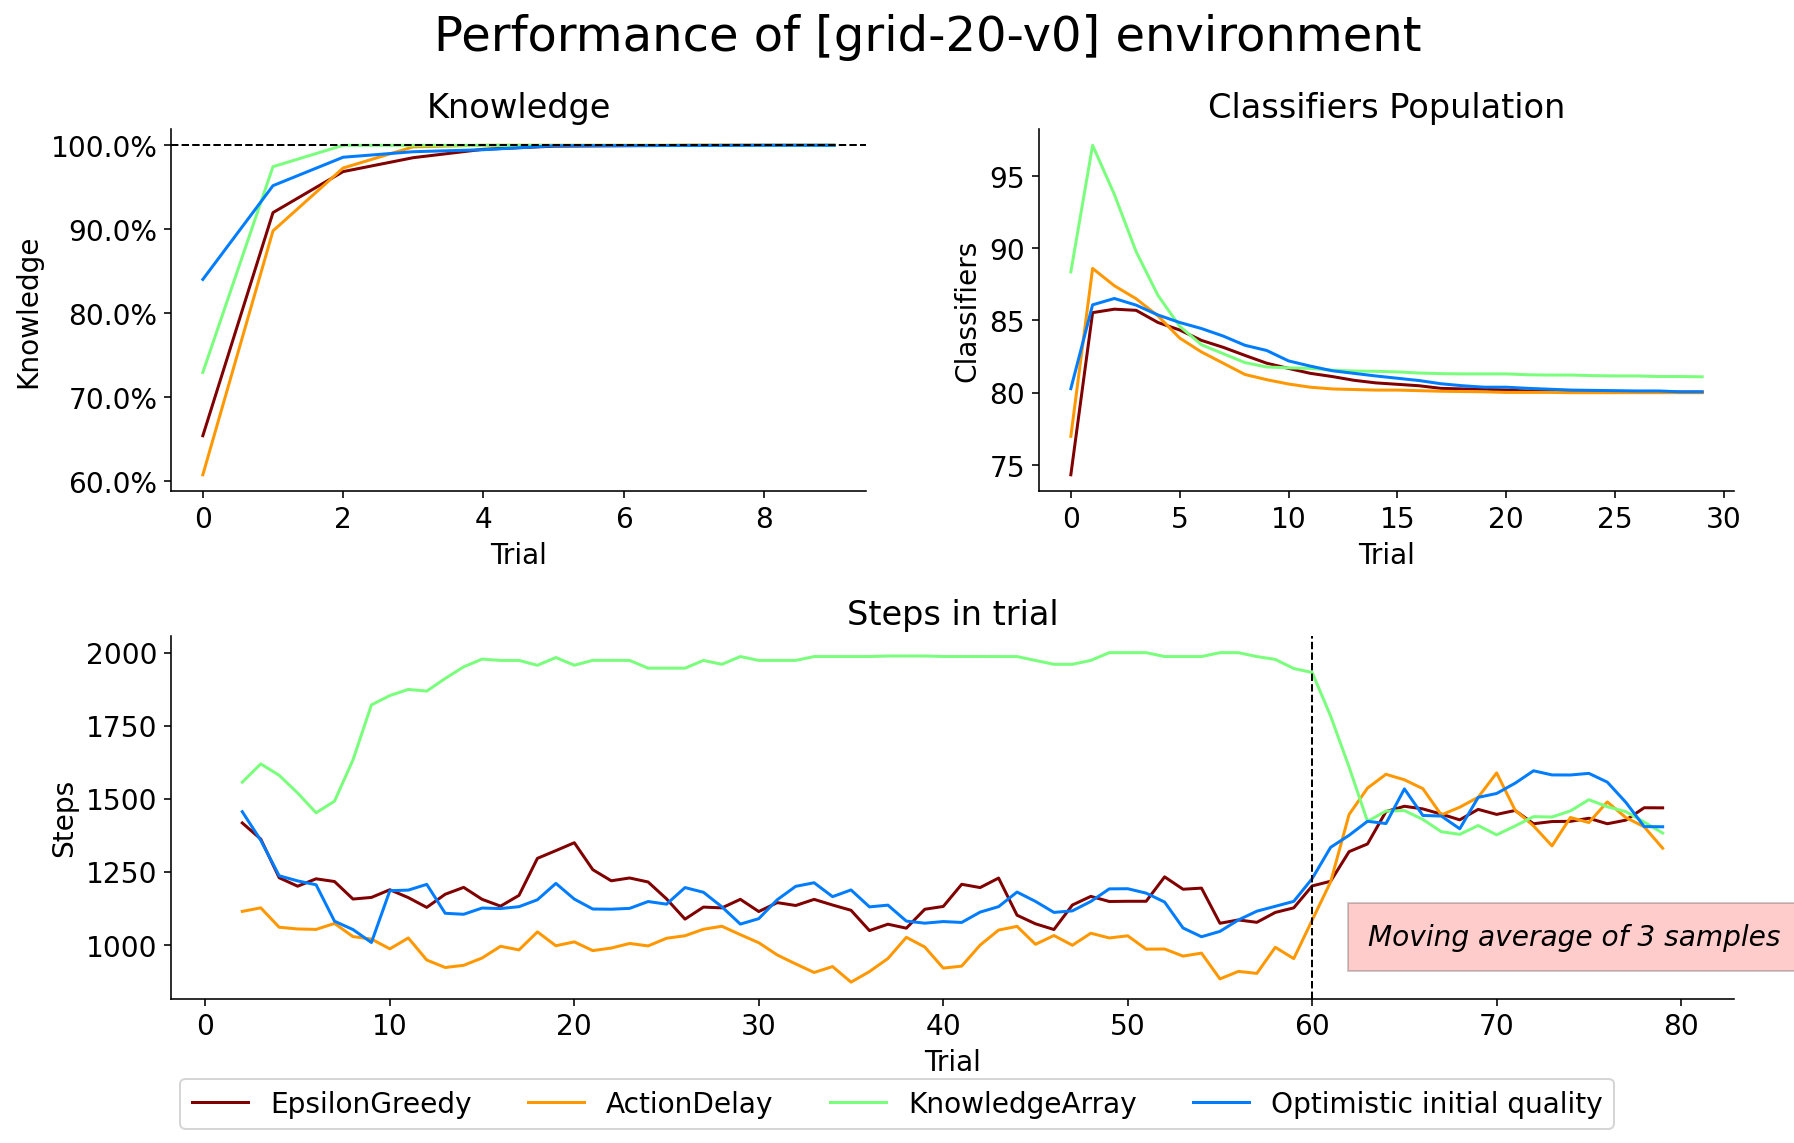

In [22]:
fig = plt.figure(figsize=(14, 8))

# Layout
gs = fig.add_gridspec(2,2, wspace=.25, hspace=.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment', fontsize=24)

# Each axis

# Knowledge
ax1_first = 10  # numer of first trials to show on plot

epsilon_greedy_df['knowledge'][:ax1_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax1)
action_delay_df['knowledge'][:ax1_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax1)
knowledge_array_df['knowledge'][:ax1_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax1)
op_initial_df['knowledge'][:ax1_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Knowledge');
ax1.set_xlabel('Trial')
ax1.set_ylabel('Knowledge')
ax1.axhline(y=100, color='black', linewidth=1, linestyle="--")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())


# Population
ax2_first = 30

epsilon_greedy_df['population'][:ax2_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['population'][:ax2_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['population'][:ax2_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['population'][:ax2_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers')
ax2.set_title('Classifiers Population');
# ax2.set_ylim(17, 40)
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Steps in trial
window = 3 # window for moving average
epsilon_greedy_df['steps_in_trial'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax3)
action_delay_df['steps_in_trial'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax3)
knowledge_array_df['steps_in_trial'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax3)
op_initial_df['steps_in_trial'].rolling(window=window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax3)


ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('Trial')
ax3.set_ylabel('Steps')
ax3.set_title('Steps in trial')
ax3.axvline(x=explore_trials, color='black', linewidth=1, linestyle="--")
ax3.text(63, 1000, f'Moving average of {window} samples', style='italic', bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 10})

# Create legend
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
fig.savefig('grid-performance.pdf')